In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pyproj
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, OCEAN, LAKES, BORDERS

import shapely.geometry as sgeom
from copy import copy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib.font_manager import FontProperties

import netCDF4 as nc

import re  # regular expression

%matplotlib inline

In [2]:
def get_wps_param_value(wps_file, param_name, noutput, vartype):
    with open(wps_file, 'r') as file:
        for line in file.readlines():
            words = re.split('=|\s+|,|\'', line)
            while '' in words:
                words.remove('')
            if param_name in words:
                if noutput==1:
                    if vartype=='float':
                        output = float(words[1])
                    elif vartype=='int':
                        output = int(words[1])
                    else:
                        output = words[1]
                if noutput>1:
                    if vartype=='float':
                        output = np.ones((noutput,1))*1.1
                        for i in np.arange(noutput):
                            output[i] = float(words[1+i])
                    elif vartype=='int':
                        output = np.ones((noutput,1))
                        for i in np.arange(noutput):
                            output[i] = int(words[1+i])
                    else:
                        output = words[1:(1+noutput)]
                    
    return output

In [3]:
def get_proj_lcc(wps_file):
    ref_lat = get_wps_param_value(wps_file, 'ref_lat', 1, 'float')
    ref_lon = get_wps_param_value(wps_file, 'ref_lon', 1, 'float')
    par_lat1 = get_wps_param_value(wps_file, 'truelat1', 1, 'float')
    par_lat2 = get_wps_param_value(wps_file, 'truelat2', 1, 'float')
    standard_lon = get_wps_param_value(wps_file, 'stand_lon', 1, 'float')
    
    lccproj = ccrs.LambertConformal(central_longitude=ref_lon, central_latitude=ref_lat,
                                    standard_parallels=(par_lat1, par_lat2), globe=None, cutoff=10)
    return lccproj

In [4]:
def calc_corner_point_latlon(center_lat, center_lon, e_we, e_ns, dx, dy, wpsproj, latlonproj, loc):
    center_x, center_y = wpsproj.transform_point(center_lon, center_lat, latlonproj)
    if loc=='ll':
        xpt = center_x - dx*e_we/2.0
        ypt = center_y - dy*e_ns/2.0
    elif loc=='lr':
        xpt = center_x + dx*e_we/2.0
        ypt = center_y - dy*e_ns/2.0
    elif loc=='ul':
        xpt = center_x - dx*e_we/2.0
        ypt = center_y + dy*e_ns/2.0
    elif loc=='ur':
        xpt = center_x + dx*e_we/2.0
        ypt = center_y + dy*e_ns/2.0
    corner_lon, corner_lat = latlonproj.transform_point(xpt, ypt, wpsproj)
    
    return corner_lon, corner_lat

In [5]:
def calc_center_point_latlon(corner_lat_parent, corner_lon_parent, dx_parent, dy_parent, e_we, e_ns, dx, dy, i, j, wpsproj, latlonproj):
    corner_x_parent, corner_y_parent = wpsproj.transform_point(corner_lon_parent, corner_lat_parent, latlonproj)
    center_x_child = corner_x_parent + dx_parent*i + dx*e_we/2.0
    center_y_child = corner_y_parent + dy_parent*j + dy*e_ns/2.0
    center_lon_child, center_lat_child = latlonproj.transform_point(center_x_child, center_y_child, wpsproj)
    
    return center_lon_child, center_lat_child

In [6]:
get_wps_param_value('namelist.wps', 'max_dom', 1, 'int')

2

In [7]:
def calc_wps_domain_info(wps_file):
    ndomain = get_wps_param_value(wps_file, 'max_dom', 1, 'int')
    proj_name = get_wps_param_value(wps_file, 'map_proj', 1, '')

    grid_ratios = get_wps_param_value(wps_file, 'parent_grid_ratio', ndomain, 'int')
    i_parent_start_array = get_wps_param_value(wps_file, 'i_parent_start', ndomain, 'int')
    j_parent_start_array = get_wps_param_value(wps_file, 'j_parent_start', ndomain, 'int')
    e_we_array = get_wps_param_value(wps_file, 'e_we', ndomain, 'int')
    e_ns_array = get_wps_param_value(wps_file, 'e_sn', ndomain, 'int')
    dx_d01 = get_wps_param_value(wps_file, 'dx', 1, 'float')
    dy_d01 = get_wps_param_value(wps_file, 'dy', 1, 'float')
    cen_lat_d01 = get_wps_param_value(wps_file, 'ref_lat', 1, 'float')
    cen_lon_d01 = get_wps_param_value(wps_file, 'ref_lon', 1, 'float')
    
    center_lat_full = np.zeros((ndomain, 1))
    center_lon_full = np.zeros((ndomain, 1))
    half_size_ns_full = np.zeros((ndomain, 1))
    half_size_we_full = np.zeros((ndomain, 1))
    corner_lat_full = np.zeros((ndomain, 4)) # ll, lr, uf, ur
    corner_lon_full = np.zeros((ndomain, 4)) # ll, lr, uf, ur
    dx_full = np.zeros((ndomain, 1))
    dy_full = np.zeros((ndomain, 1))
    length_x = np.zeros((ndomain, 1))
    length_y = np.zeros((ndomain, 1))
       
    # get WPS projection info
    # LCC
    if proj_name=='lambert':
        wpsproj = get_proj_lcc(infile)
    
    # Geodetic, for lat/lon projection
    latlonproj = ccrs.Geodetic()
    
    # d01
    dx_full[0] = dx_d01
    dy_full[0] = dy_d01
    center_lat_full[0] = cen_lat_d01
    center_lon_full[0] = cen_lon_d01
    length_x[0] = dx_full[0]*e_we_array[0]
    length_y[0] = dy_full[0]*e_ns_array[0]
    if ndomain>1:
        e_we = int(e_we_array[0])
        e_ns = int(e_ns_array[0])
    else:
        e_we = e_we_array
        e_ns = e_ns_array
    corner_lon_full[0,0], corner_lat_full[0,0] = calc_corner_point_latlon(float(center_lat_full[0]), float(center_lon_full[0]),
                                                                          e_we, e_ns, 
                                                                          float(dx_full[0]), float(dy_full[0]),
                                                                          wpsproj, latlonproj, 'll')
    corner_lon_full[0,1], corner_lat_full[0,1] = calc_corner_point_latlon(center_lat_full[0], center_lon_full[0],
                                                                          e_we, e_ns,
                                                                          dx_full[0], dy_full[0],
                                                                          wpsproj, latlonproj, 'lr')
    corner_lon_full[0,2], corner_lat_full[0,2] = calc_corner_point_latlon(center_lat_full[0], center_lon_full[0],
                                                                          e_we, e_ns,
                                                                          dx_full[0], dy_full[0],
                                                                          wpsproj, latlonproj, 'ul')
    corner_lon_full[0,3], corner_lat_full[0,3] = calc_corner_point_latlon(center_lat_full[0], center_lon_full[0],
                                                                          e_we, e_ns, 
                                                                          dx_full[0], dy_full[0],
                                                                          wpsproj, latlonproj, 'ur')
    
    if ndomain>1:
        for i in np.arange(1,ndomain):
            dx_full[i] = dx_full[i-1]/float(grid_ratios[i])
            dy_full[i] = dy_full[i-1]/float(grid_ratios[i])
            length_x[i] = dx_full[i]*e_we_array[i]
            length_y[i] = dy_full[i]*e_ns_array[i]
            center_lon_full[i], center_lat_full[i] = calc_center_point_latlon(corner_lat_full[i-1,0], corner_lon_full[i-1,0],
                                                                              dx_full[i-1], dy_full[i-1],
                                                                              e_we_array[i], e_ns_array[i],
                                                                              dx_full[i], dy_full[i],
                                                                              i_parent_start_array[i], j_parent_start_array[i],
                                                                              wpsproj, latlonproj)
            corner_lon_full[i,0], corner_lat_full[i,0] = calc_corner_point_latlon(center_lat_full[i], center_lon_full[i],
                                                                              e_we_array[i], e_ns_array[i], 
                                                                              dx_full[i], dy_full[i],
                                                                              wpsproj, latlonproj, 'll')
            corner_lon_full[i,1], corner_lat_full[i,1] = calc_corner_point_latlon(center_lat_full[i], center_lon_full[i],
                                                                              e_we_array[i], e_ns_array[i], 
                                                                              dx_full[i], dy_full[i],
                                                                              wpsproj, latlonproj, 'lr')
            corner_lon_full[i,2], corner_lat_full[i,2] = calc_corner_point_latlon(center_lat_full[i], center_lon_full[i],
                                                                              e_we_array[i], e_ns_array[i], 
                                                                              dx_full[i], dy_full[i],
                                                                              wpsproj, latlonproj, 'ul')
            corner_lon_full[i,3], corner_lat_full[i,3] = calc_corner_point_latlon(center_lat_full[i], center_lon_full[i],
                                                                              e_we_array[i], e_ns_array[i], 
                                                                              dx_full[i], dy_full[i],
                                                                              wpsproj, latlonproj, 'ur')
    
    return wpsproj, latlonproj, corner_lat_full, corner_lon_full, length_x, length_y

In [8]:
def reproject_corners(corner_lons, corner_lats, wpsproj, latlonproj):
    corner_x = np.zeros((4,1))
    corner_y = np.zeros((4,1))
    corner_x[0], corner_y[0] = wpsproj.transform_point(corner_lons[0], corner_lats[0], latlonproj)
    corner_x[1], corner_y[1] = wpsproj.transform_point(corner_lons[1], corner_lats[1], latlonproj)
    corner_x[2], corner_y[2] = wpsproj.transform_point(corner_lons[2], corner_lats[2], latlonproj)
    corner_x[3], corner_y[3] = wpsproj.transform_point(corner_lons[3], corner_lats[3], latlonproj)

    return corner_x, corner_y

In [9]:
# all these functions are necessary only when LCC projection is used.
def find_side(ls, side):
    """
    Given a shapely LineString which is assumed to be rectangular, return the
    line corresponding to a given side of the rectangle.
    
    """
    minx, miny, maxx, maxy = ls.bounds
    points = {'left': [(minx, miny), (minx, maxy)],
              'right': [(maxx, miny), (maxx, maxy)],
              'bottom': [(minx, miny), (maxx, miny)],
              'top': [(minx, maxy), (maxx, maxy)],}
    return sgeom.LineString(points[side])


def lambert_xticks(ax, ticks, size):
    """Draw ticks on the bottom x-axis of a Lambert Conformal projection."""
    te = lambda xy: xy[0]
    lc = lambda t, n, b: np.vstack((np.zeros(n) + t, np.linspace(b[2], b[3], n))).T
    xticks, xticklabels = _lambert_ticks(ax, ticks, 'bottom', lc, te)
    ax.xaxis.tick_bottom()
    ax.set_xticks(xticks)
    ax.set_xticklabels([ax.xaxis.get_major_formatter()(xtick) for xtick in xticklabels], size=size)
    

def lambert_yticks_left(ax, ticks, size):
    """Draw ricks on the left y-axis of a Lamber Conformal projection."""
    te = lambda xy: xy[1]
    lc = lambda t, n, b: np.vstack((np.linspace(b[0], b[1], n), np.zeros(n) + t)).T
    yticks, yticklabels = _lambert_ticks(ax, ticks, 'left', lc, te)
    ax.yaxis.tick_left()
    ax.set_yticks(yticks)
    ax.set_yticklabels([ax.yaxis.get_major_formatter()(ytick) for ytick in yticklabels], size=size)

    
def lambert_yticks_right(ax, ticks, size):
    """Draw ricks on the left y-axis of a Lamber Conformal projection."""
    te = lambda xy: xy[1]
    lc = lambda t, n, b: np.vstack((np.linspace(b[0], b[1], n), np.zeros(n) + t)).T
    yticks, yticklabels = _lambert_ticks(ax, ticks, 'right', lc, te)
    ax.yaxis.tick_right()
    ax.set_yticks(yticks)
    ax.set_yticklabels([ax.yaxis.get_major_formatter()(ytick) for ytick in yticklabels], size=size)

def _lambert_ticks(ax, ticks, tick_location, line_constructor, tick_extractor):
    """Get the tick locations and labels for an axis of a Lambert Conformal projection."""
    outline_patch = sgeom.LineString(ax.outline_patch.get_path().vertices.tolist())
    axis = find_side(outline_patch, tick_location)
    n_steps = 30
    extent = ax.get_extent(ccrs.PlateCarree())
    _ticks = []
    for t in ticks:
        xy = line_constructor(t, n_steps, extent)
        proj_xyz = ax.projection.transform_points(ccrs.Geodetic(), xy[:, 0], xy[:, 1])
        xyt = proj_xyz[..., :2]
        ls = sgeom.LineString(xyt.tolist())
        locs = axis.intersection(ls)
        if not locs:
            tick = [None]
        else:
            tick = tick_extractor(locs.xy)
        _ticks.append(tick[0])
    # Remove ticks that aren't visible:    
    ticklabels = copy(ticks)
    while True:
        try:
            index = _ticks.index(None)
        except ValueError:
            break
        _ticks.pop(index)
        ticklabels.pop(index)
    return _ticks, ticklabels

# intermediate functions

In [10]:
etopo1file = 'ETOPO1_clipped.nc'
rootgroup = nc.Dataset(etopo1file, 'r', format='NETCDF4')
dem = rootgroup.variables['z'][:]
dem_lat = rootgroup.variables['x'][:]
dem_lon = rootgroup.variables['y'][:]
rootgroup.close()

dem_lons,dem_lats = np.meshgrid(dem_lat,dem_lon)

for i in np.arange(dem.shape[0]):
    for j in np.arange(dem.shape[1]):
        if dem[i,j]<0:
            dem[i,j]=0

# main code

In [12]:
infile = 'namelist.wps'
wpsproj, latlonproj, corner_lat_full, corner_lon_full, length_x, length_y = calc_wps_domain_info(infile)

/home/dargueso/anaconda3/envs/e3_rehipre_env/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: set_ticks() must have been called.


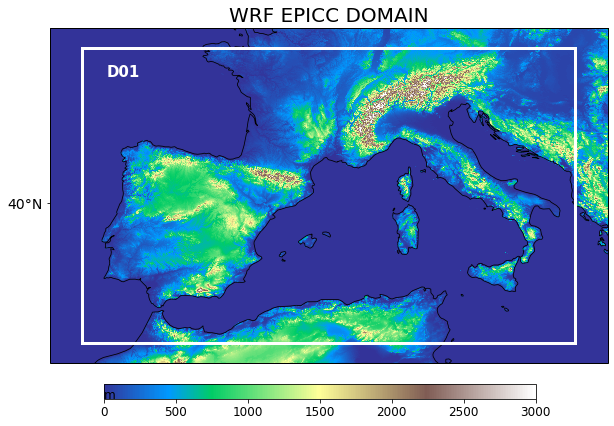

In [19]:
fig1 = plt.figure(figsize=(10,10))
ax1 = plt.axes(projection=wpsproj)


hgt=ax1.pcolormesh(dem_lons, dem_lats, dem, cmap='terrain', vmin=0, vmax=3000, alpha=1, transform=ccrs.PlateCarree())
ax1.coastlines('50m', linewidth=0.8)
ax1.add_feature(OCEAN, edgecolor='k')#, facecolor='deepskyblue')
ax1.add_feature(LAKES, edgecolor='k')#, facecolor='deepskyblue')
states = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_1_states_provinces_shp')
ax1.add_feature(states, linewidth=0.5)

font0 = FontProperties()
font0.set_weight('bold')

# d01
corner_x1, corner_y1 = reproject_corners(corner_lon_full[0,:], corner_lat_full[0,:], wpsproj, latlonproj)
ax1.set_xlim([corner_x1[0]-length_x[0]/15, corner_x1[3]+length_x[0]/15])
ax1.set_ylim([corner_y1[0]-length_y[0]/15, corner_y1[3]+length_y[0]/15])

# d01 box
ax1.add_patch(mpl.patches.Rectangle((corner_x1[0], corner_y1[0]),  length_x[0], length_y[0], 
                                    fill=None, lw=3, edgecolor='white', zorder=10))
ax1.text(corner_x1[0]+length_x[0]*0.05, corner_y1[0]+length_y[0]*0.9, 'D01',
         fontproperties=font0, size=15, color='white', zorder=10)

# d02 box
# corner_x2, corner_y2 = reproject_corners(corner_lon_full[1,:], corner_lat_full[1,:], wpsproj, latlonproj)
# ax1.add_patch(mpl.patches.Rectangle((corner_x2[0], corner_y2[0]),  length_x[1], length_y[1], 
#                                     fill=None, lw=3, edgecolor='gold', zorder=10))
# ax1.text(corner_x2[0]+length_x[1]*0.05, corner_y2[0]+length_y[1]*1.1, 'D02',
#          fontproperties=font0, size=15, color='gold', zorder=10)


fig1.canvas.draw()


xticks = [-150, -140, -130, -120, -110, -100, -90, -80, -70, -60, -50]
yticks = [10, 20, 30, 40, 50, 60, 70]
ax1.gridlines(xlocs=xticks, ylocs=yticks)
ax1.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax1.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax1, xticks, 14)
lambert_yticks_left(ax1, yticks, 14)

ax1.set_title('WRF EPICC DOMAIN', size=20)

cbar_ax = fig1.add_axes([0.2, 0.22, 0.6, 0.02])
cb1=plt.colorbar(hgt, cax=cbar_ax,orientation="horizontal")
cb1.set_ticklabels(['0','1000','2000', '3000', '4000'])
cbar_ax.tick_params(labelsize=12)
cbar_ax.text(0.5, 0.1, 'm', size=12)

plt.show()

In [14]:
fig1.savefig('WRF_EPICC_domain.png', dpi=600)